In [283]:
# To Do:
# * Include introduction saying that we could have better data as it relates to genderqueer / non-binary individuals so that programs can be more specific to support these individuals
# Include importance around early childhood development in intro
# Include in intro question of whether it is fair to do machine learning from this dataset because numbers are based on a ton of dependent variables
# Talk about clear lack of data and consequences for application of tool
# Generalize functions to look at overall displaced individuals or by country totals
# Right now I am wondering about the age ranges 5 - 11, 5 - 17, 12 - 17 and if there is a better way to split data-wise than just summing. Until 2005 they didn't split the age range
# Clustering for each country geographically
# R^2 jumps all around (see if I can test variance)
# Add a readme.md on github


## Introduction

We are currently experiencing the largest refugee crisis that we have globally seen [1]. Over the past decade, the number of refugees and displaced persons has skyrocketed, and it is imperitive that services to support these individuals are in place throughout the relocation process. Importantly, services must be specified to the individual and family level so the we are correctly assisting those who require it. Using historical trends, we can better understand the demographics of displaced individuals. 

The United Nations Refugee Agency (UNHCR) collects demographic data around displaced individuals [2]. We can utilize this data to look at the different number of individuals from countries and locations by age and sex. This will better the ability for non-profits and humanitarian organizations to plan their services strategically to benefit the most individuals. For example, they will have a better idea as to how many women-specific and early-age development programs are needed. Having an understanding of where individuals are coming from will also better the ability to plan language integration services, job planning and relocation within specific communities.

Specifically, this tool will provide demographic trends given a specific country of origin (or total numbers across a specific group of countries) and demographic (sex/age range). Data insights will be provided temporally through digestible visuals.

In [284]:
# import libraries

import pandas as pd
import numpy as np
import pdb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline


## Pre-processing of data

In [285]:
# pre-processing of data

# data: http://popstats.unhcr.org/en/demographics
import_path = './unhcr_popstats_export_demographics_2019_12_23_152351.csv'
demographics_df = pd.read_csv(import_path, header = 2)

demographics_df.head()


,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,West,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
1,2001,Afghanistan,Various,14335,NaN,45451.0,NaN,99880,19234,412004.0,590904,14716,NaN,47522.0,NaN,114965,13025,435492.0,625720
2,2001,Afghanistan,North,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
3,2001,Afghanistan,Kabul,NaN,NaN,1.0,NaN,1,NaN,0.0,2,NaN,NaN,0.0,NaN,2,NaN,0.0,2
4,2001,Afghanistan,Herat,NaN,NaN,0.0,NaN,1,NaN,0.0,1,NaN,NaN,0.0,NaN,1,NaN,0.0,1


In [286]:
# Cleaning data

# convert ages to integers because you can't have half of a person
# assuming that all '*' values are 0
def clean_convert_unhcr_data(col):
    '''Clean mislabeled data for demographic levels
    '''
    demographics_df[col] = demographics_df[col].fillna(0).replace('*', 0).astype(int)

# The 'total' columns are sums of all other columns for each gender, but there is overlap among a few columns
def add_cols(col, col_list):
    '''Coalesce demographics with overlapping data
    '''
    demographics_df[col] = demographics_df[col_list].sum(axis = 1)
    
    
demographics_columns = ['Female 0-4','Female 5-11','Female 5-17','Female 12-17',
                        'Female 18-59','Female 60+','F: Unknown','F: Total',
                        'Male 0-4','Male 5-11','Male 5-17','Male 12-17',
                        'Male 18-59','Male 60+','M: Unknown','M: Total']

for col in demographics_columns:
    clean_convert_unhcr_data(col)
    
# Add columns to clean inconsistencies in data tabulation
add_cols('Female 5-17',['Female 5-11','Female 5-17','Female 12-17'])
add_cols('Male 5-17',['Male 5-11','Male 5-17','Male 12-17'])

# Dropping columns after adding together, dropping location name as this project is tailored
# to the country level
cols_to_drop = ['Female 5-11', 'Female 12-17', 'Male 5-11', 'Male 12-17','Location Name']

demographics_df = demographics_df.drop(cols_to_drop, axis = 1)
demographics_df = demographics_df.groupby(['Year','Country / territory of asylum/residence']).sum().reset_index()

# find countries with only one entry as you can't make a regression off of one entry
for country in demographics_df['Country / territory of asylum/residence'].unique():
    count = demographics_df[demographics_df['Country / territory of asylum/residence'] == country]['Country / territory of asylum/residence'].count()
    if count == 1:
        demographics_df = demographics_df[demographics_df['Country / territory of asylum/residence'] != country]



## Functions Assignment

In [287]:
def specify_country(dataframe_input, country):
    '''This is utilized to filter a dataset across all countries to one specific one.
    '''
    dataframe_output = dataframe_input[dataframe_input['Country / territory of asylum/residence'] == country]
    return dataframe_output
    
def lin_reg(dataframe_input, demographic, test_size):
    '''This builds the linear regression model for a specific dataset. 
    First it converts x and y data to numpy arrays and then creates a linear regression model.
    '''
    
    x_data = country_specified_dataframe['Year'].values.reshape(-1, 1)
    y_data = country_specified_dataframe[demographic].values.reshape(-1, 1)
    
    # create training and testing datasets, pick a small test_size as there isn't a lot of data
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = test_size)

    # create linear regression object
    lr = linear_model.LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    linear_regression_list = [lr.coef_[0][0], lr.intercept_[0], test_size, r2_score(y_test, y_pred)]

    return linear_regression_list


def get_max_r_squared(dataframe_input, demographic, country):
    '''This is used to iterate over different test_sizes for train/test/split such that we can get a max R squared value.
    '''
    
    cols_max_r2 = ['coefficient', 'intercept', 'test_size','r_squared']
    appended_data = []
    # can't go higher than 0.3, otherwise not enough data is in the fitting process
    test_size_range = np.linspace(0.01, 0.3, 100, endpoint = False) 

    for i in test_size_range:
        appended_data.append(lin_reg(dataframe_input = dataframe_input, demographic = demographic, test_size = i))
    
    r2_df = pd.DataFrame(appended_data, columns = cols_max_r2)

    # get max value for R^2, if there is more than one pull duplicates are coming from when there is no statistical 
    # trend and therefore R^2 = 1.0
    max_r2 = r2_df[r2_df['r_squared'] == r2_df['r_squared'].max()].reset_index(drop = True).iloc[:1]
    max_r2['demographic'] = demographic
    max_r2['country'] = country
    max_r2 = max_r2[['country','demographic', 'coefficient', 'intercept', 'test_size', 'r_squared',]]
    return max_r2


In [288]:
# test the return of a single country and demographic input

country_input, demographic = 'Cambodia', 'Female 5-17'

country_specified_dataframe = specify_country(demographics_df, country_input)
get_max_r_squared(country_specified_dataframe, demographic, country_input)


,country,demographic,coefficient,intercept,test_size,r_squared
0,Cambodia,Female 5-17,-1.351642,2735.734518,0.1927,0.696842


In [289]:
# test list of countries
test_country_list_df = pd.DataFrame({'country': ['Samoa', 'Iceland', 'Afghanistan', 'Rep. of Korea', 'Burkina Faso', 'Bosnia and Herzegovina']})
test_country_list = test_country_list_df['country']

# full list of countries
full_country_list = demographics_df['Country / territory of asylum/residence'].sort_values().unique()

# full list of demographics
demographics_list = pd.DataFrame({'demographic': ['Female 0-4', 
                                                  'Female 5-17', 
                                                  'Female 18-59', 
                                                  'Female 60+', 
                                                  'Male 0-4', 
                                                  'Male 5-17', 
                                                  'Male 18-59', 
                                                  'Male 60+',
                                                 ]})


cols_final_df = ['country','demographic','coefficient','intercept','test_size','r_squared']
lin_reg_list =[]

# iterate over each country and demographic in dataframes
for country in full_country_list:
    for demographic in demographics_list['demographic']:
        country_specified_dataframe = specify_country(demographics_df, country)
        lin_reg_object = get_max_r_squared(country_specified_dataframe, demographic, country)
        lin_reg_list.append(lin_reg_object)
        
overall_lin_reg_df = pd.concat(lin_reg_list, ignore_index = True)

# sort countries and demographic
overall_lin_reg_df = overall_lin_reg_df.sort_values(by = ['country', 'demographic']).reset_index(drop = True)

overall_lin_reg_df.to_csv('./regression_values_overall.csv', index = False)
overall_lin_reg_df.head(10)


,country,demographic,coefficient,intercept,test_size,r_squared
0,Afghanistan,Female 0-4,9478.683481,-1.893124e+07,0.0825,0.863423
1,Afghanistan,Female 18-59,1306.148116,-2.229228e+06,0.1231,0.026668
2,Afghanistan,Female 5-17,9300.933287,-1.838082e+07,0.1521,0.570219
3,Afghanistan,Female 60+,-1135.467953,2.326306e+06,0.0999,0.812725
4,Afghanistan,Male 0-4,7304.061392,-1.455888e+07,0.2739,0.709866
5,Afghanistan,Male 18-59,-4629.192791,9.730662e+06,0.0912,0.222341
6,Afghanistan,Male 5-17,7721.255952,-1.518218e+07,0.1173,0.463404
7,Afghanistan,Male 60+,-63.316434,1.741204e+05,0.1347,0.016235
8,Albania,Female 0-4,22.212078,-4.454561e+04,0.0912,0.947100
9,Albania,Female 18-59,97.165914,-1.948382e+05,0.1347,0.879184


## Data Visualization

In [290]:
# The generation of the overall linear regression dataframe takes awhile to run, 
# so we can just load it in for time's sake

input_path = './regression_values_overall.csv'
overall_table_regression = pd.read_csv(input_path)

overall_table_regression.head()

,country,demographic,coefficient,intercept,test_size,r_squared
0,Afghanistan,Female 0-4,9478.683481,-1.893124e+07,0.0825,0.863423
1,Afghanistan,Female 18-59,1306.148116,-2.229228e+06,0.1231,0.026668
2,Afghanistan,Female 5-17,9300.933287,-1.838082e+07,0.1521,0.570219
3,Afghanistan,Female 60+,-1135.467953,2.326306e+06,0.0999,0.812725
4,Afghanistan,Male 0-4,7304.061392,-1.455888e+07,0.2739,0.709866


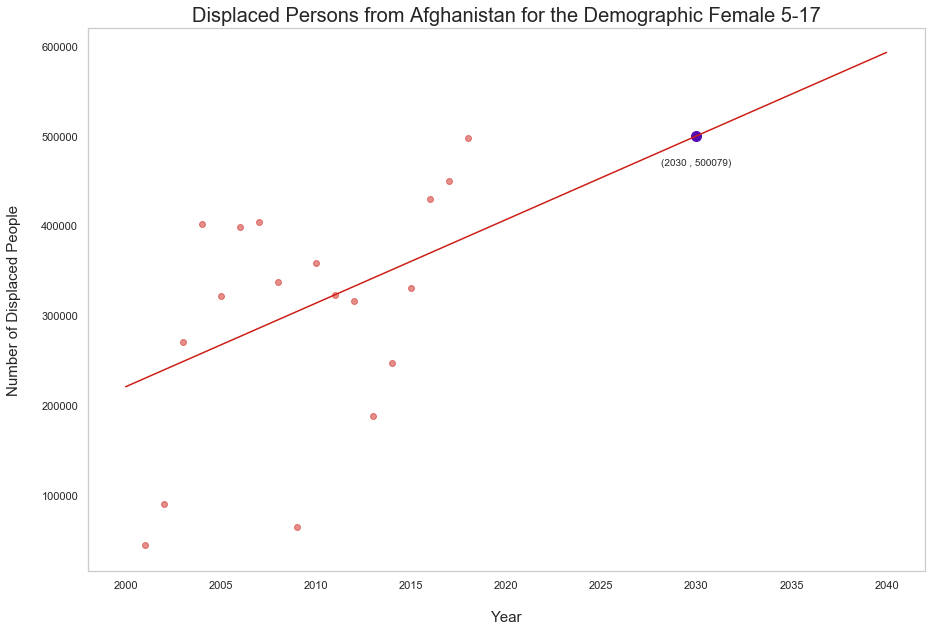

The total number of displaced people in 2030 will be 500079


In [291]:
# does a dropdown option exist within jupyter?
# add textbox
# overlay 
plt.rcParams["figure.figsize"] = [15, 10]

def prediction_visualization(country_user_input, demographic_user_input, year_user_input):
    '''This plots the historical data, predictive trendline and predicted plot point based on user inputu year
    '''

    # locate slice from dataframe via index
    user_input_slice = overall_table_regression[(overall_table_regression['country'] == country_user_input) & 
                                                (overall_table_regression['demographic'] == demographic_user_input)].reset_index(drop = True)

    coefficient = user_input_slice.at[0, 'coefficient']
    intercept = user_input_slice.at[0, 'intercept']


    tabulated_data = demographics_df[demographics_df['Country / territory of asylum/residence'] == country_user_input][['Year', demographic_user_input]]

    x_pred = np.linspace(2000, 2040, 41)
    y_pred = (coefficient * x_pred) + intercept
    predicted_data = pd.DataFrame({'Year': x_pred, demographic_user_input: (coefficient * x_pred) + intercept})

    # Plot Data
    plt.plot('Year', demographic_user_input, data = predicted_data, c = '#CD1E16')
    plt.scatter('Year', demographic_user_input, data = tabulated_data, c = '#CD1E16', alpha = 0.5)
    plt.scatter(year_user_input, (coefficient * year_user_input) + intercept, s = 100, c = '#530AB0')

    # label predicted point
    label = '({} , {})'.format(year_user_input, int(round((coefficient * year_user_input) + intercept)))
    plt.annotate(label,
                 (year_user_input, (coefficient * year_user_input) + intercept),
                 textcoords = "offset points",
                 xytext = (0, -30),
                 ha = 'center',
                )

    # set title, axes
    plt.title('Displaced Persons from {} for the Demographic {}'.format(country_user_input, demographic_user_input), 
              fontsize = 20)
    plt.xlabel('Year', fontsize = 15, labelpad = 20)
    plt.ylabel('Number of Displaced People', fontsize = 15, labelpad = 20)
    
    plt.show()
    
    # set predicted statement
    print('The total number of displaced people in {} will be {}'.format(year_user_input, int(round((coefficient * year_user_input) + intercept))))
    
prediction_visualization('Afghanistan', 'Female 5-17', 2030)

#### References:

#### [1]: https://www.unhcr.org/blogs/statistics-refugee-numbers-highest-ever/
#### [2]: http://popstats.unhcr.org/en/demographics
#### [3]: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html